In [37]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict

from utils import *

In [38]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [39]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True
all_configs = []

## Generalized Stitching Configs

In [ ]:
def generalized_grouping_func(config):
    result = ''
    if config['agent']['agent_name'] == 'gcdqn':
        result += 'GCDQN'
    elif config['agent']['agent_name'] == 'clearn_search':
        result += "C-LEARN"
    else:
        result += "CRL"

    if config['agent']['is_td']:
        result += ' TD'
    else:
        result += ' MC'

    if config['agent']['net_arch'] =='mlp':
        result += ' SMALL'
    else:
        result += ' BIG'


    return result

agents = ['GCDQN', 'C-LEARN', 'CRL']
grid_sizes = [4, 5]


for grid_size in grid_sizes:

    config = {
        "directory": "generalized",
        "title": f"mc_generalized_3_boxes_2_movable_{grid_size}_grid",
        "projects":["paper_generalized"],
        "possible_names":[' '.join([agent, s]) for agent in agents for s in ['MC BIG', 'MC SMALL']],
        "filters":{
            "config.agent.is_td": False,
            "config.agent.net_arch": "mlp",
            "config.env.grid_size": grid_size,
            "config.env.number_of_boxes_max":3,
            "config.env.number_of_moving_boxes_max":2,
        },
        "grouping_func": generalized_grouping_func,
        "metrics": OrderedDict([
            ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
            ("eval_3/mean_success", "Test success on 3 boxes \n(0 on target)"),
        ]),
    }

    all_configs.append(config)


# Plotting

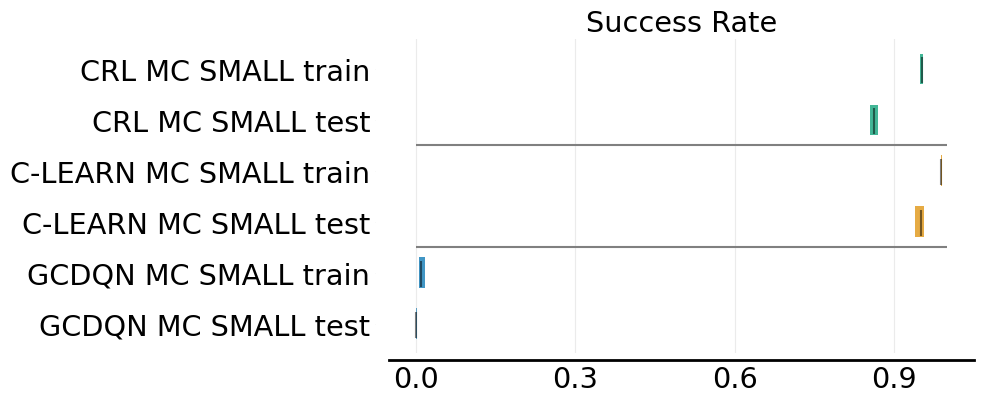

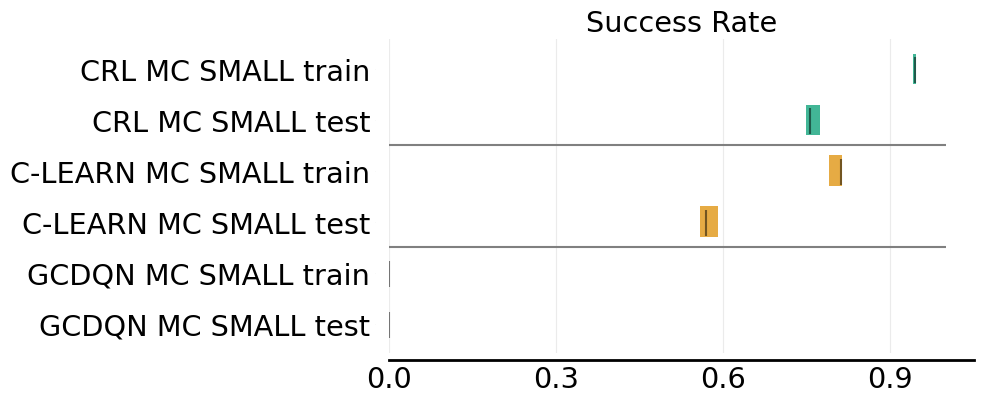

In [ ]:
for config in all_configs:
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])


    data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)


    empty_keys = []
    for k, v in data_curves.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data_curves[k]

    new_data = OrderedDict()

    for k, v in data_curves.items():
        aggregated_v = np.mean(v[:, -5:, :], axis=1)
        new_data[k + ' test'] = aggregated_v[:, 1].reshape(-1, 1)
        new_data[k + ' train'] = aggregated_v[:, 0].reshape(-1, 1)

    names = list(new_data.keys())

    metrics = OrderedDict([('', 'Success Rate')])

    path = os.path.join(figures_path, config['directory'])
    os.makedirs(path, exist_ok=True)

    draw_interval_estimates_plot_per_alg(new_data, names, metrics, config['title'], figures_path=path)

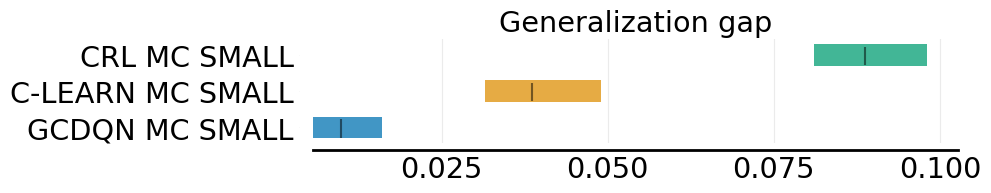

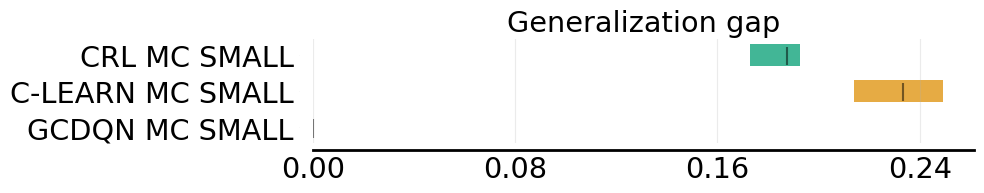

In [42]:
for config in all_configs:
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])


    data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)


    empty_keys = []
    for k, v in data_curves.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data_curves[k]

    new_data = OrderedDict()

    for k, v in data_curves.items():
        aggregated_v = np.mean(v[:, -5:, :], axis=1)
        diffs = (aggregated_v[:, 0] - aggregated_v[:, 1]).reshape(-1, 1)
        new_data[k] = diffs
                     
    config['metrics'] = OrderedDict()
    config['metrics']['eval/generalization_gap'] = "Generalization gap"

    names = list(new_data.keys())

    path = os.path.join(figures_path, config['directory'])
    os.makedirs(path, exist_ok=True)

    draw_interval_estimates_plot(new_data, names, config['metrics'], config['title'] + "_generalization_gap", figures_path=path)
